# Прогнозирование цены биткоина

Обучающие данные - это ежедневные данные о цене биткоина за предыдущие полтора года.

Тестовые данные - 7 дней после окончания обучающих данных.

Установим библиотеку CatBoost

In [41]:
!pip install catboost

Отключим вывод предупреждений

In [2]:
import warnings
warnings.filterwarnings('ignore')

Импортируем необходимые библиотеки

In [3]:
# библиотеки для обработки и анализа структурированных данных
import pandas as pd
import numpy as np

# библиотеки визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# библиотека статистических моделей
from statsmodels.tsa.seasonal import seasonal_decompose

# библиотека для машинного обучения на основе градиентного бустинга
from catboost import CatBoostRegressor

# библиотека моделей для машинного обучения
from sklearn.metrics import mean_absolute_error

Настройки визуализации

In [4]:
sns.set_theme()
sns.set(rc={'figure.figsize': (12, 4)})

## Формирование датасета

Загрузим датасет для Bitcoin

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/week8day/bitcoin-prediction/main/data/Bitcoin_kaggle.csv',
    delimiter=';',
    parse_dates=True,
    index_col='Date'
)

и дополнительные данные для Ethereum

In [6]:
e_df = pd.read_csv('https://raw.githubusercontent.com/week8day/bitcoin-prediction/main/data/Ethereum_kaggle.csv',
    delimiter=';',
    parse_dates=True,
    index_col='timeOpen'
)

*последние 7 строк для теста содержат значения, скопированные с предыдущего дня*

Сформируем рабочий датасет

In [7]:
data = df.copy()

print('Total length:', len(data))

# сортируем датасеты по дате
data = data.sort_index()
e_df = e_df.sort_index()

# добавляем в основной датасет данные из датасета для Ethereum
data['e_close'] = e_df['e_close']
data['e_open'] = e_df['e_open']
data['e_high'] = e_df['e_high']
data['e_low'] = e_df['e_low']

data.tail(15)

Total length: 547


,Price,Open,High,Low,Vol.,Change %,e_close,e_open,e_high,e_low
Date,,,,,,,,,,
2023-06-30,"30,472.9","30,445.7","31,275.5","29,714.5",118.65K,0.09%,171717.458067,160904.298875,174102.019861,160904.298875
2023-07-01,"30,586.8","30,472.9","30,649.9","30,329.0",22.46K,0.37%,170951.508510,171729.441185,172562.420954,169733.048715
2023-07-02,"30,617.7","30,587.1","30,769.0","30,227.9",28.82K,0.10%,170397.731711,170941.045463,173078.649794,166746.438816
2023-07-03,"31,151.3","30,617.5","31,377.0","30,581.5",56.49K,1.74%,175057.216686,170436.907100,176742.333265,170155.905738
2023-07-04,"30,768.4","31,152.0","31,326.5","30,657.8",42.12K,-1.23%,174300.526397,175069.304265,175069.304265,173935.037797
2023-07-05,"30,512.8","30,768.6","30,875.6","30,233.3",43.23K,-0.83%,173532.065211,174315.213906,174822.439060,171685.503716
2023-07-06,"29,913.1","30,512.8","31,463.6","29,869.0",90.81K,-1.97%,168671.212510,173516.539763,181615.750762,168599.512609
2023-07-07,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%,170711.191071,168568.662245,172040.631311,167155.604005
2023-07-08,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%,170711.191071,168568.662245,172040.631311,167155.604005


Преобразуем значения столбцов в нужный формат

In [8]:
price_columns = ['Price', 'Open', 'High', 'Low']
for col in price_columns:
    data[col] = data[col].apply(lambda x: float(x.replace(',', '')))

data['Change %'] = data['Change %'].apply(lambda x: float(x.replace('%', '')))

data = data.drop('Vol.', axis=1)

Установим константы

In [9]:
TEST_SIZE = 7 # размер тестовой выборки
RANDOM_SEED = 0 # параметр рандомизации
FOLDS_N = 10 # количество фолдов
TARGET = 'Price' # целевой признак

Выделим данные для валидации

In [10]:
data_valid = data[:-TEST_SIZE]

## Анализ данных

Выведем информацию о структуре датасета

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 547 entries, 2022-01-14 to 2023-07-14
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     547 non-null    float64
 1   Open      547 non-null    float64
 2   High      547 non-null    float64
 3   Low       547 non-null    float64
 4   Change %  547 non-null    float64
 5   e_close   547 non-null    float64
 6   e_open    547 non-null    float64
 7   e_high    547 non-null    float64
 8   e_low     547 non-null    float64
dtypes: float64(9)
memory usage: 42.7 KB


Датасет не содержит пропусков, все признаки имеют числовой тип `float`.

Выведем график изменения цены, отметим линию тренда

<Axes: xlabel='Date'>

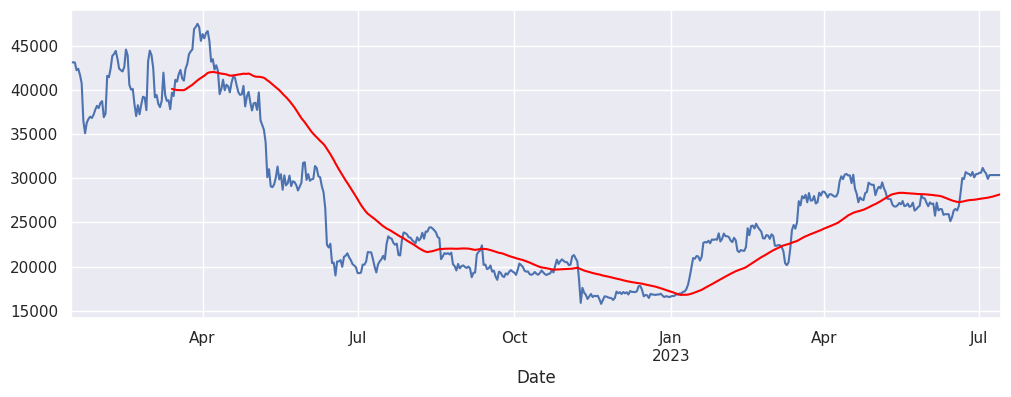

In [12]:
data[TARGET].plot()
r = data[TARGET].rolling(window=60)
rolling_mean = r.mean()
rolling_mean.plot(color='red')

Выведем график изменения цены Bitcoin и Ethereum для последних 200 записей

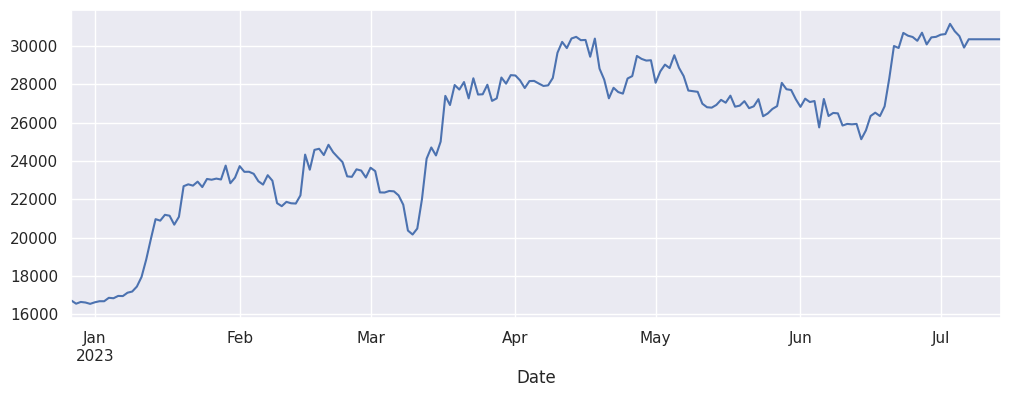

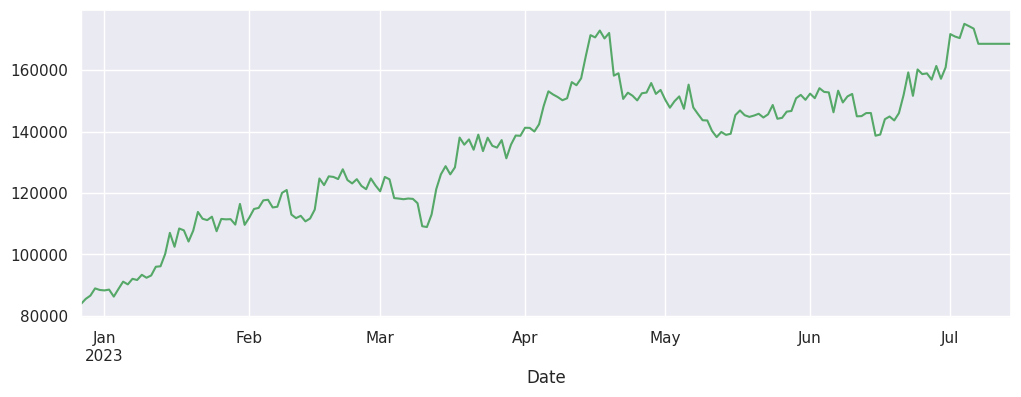

In [13]:
data[-200:][TARGET].plot()
plt.show()

data[-200:]['e_open'].plot(color='g')
plt.show()

Между Bitcoin и Ethereum заметна корреляция, что подтверждается матрицей корреляций

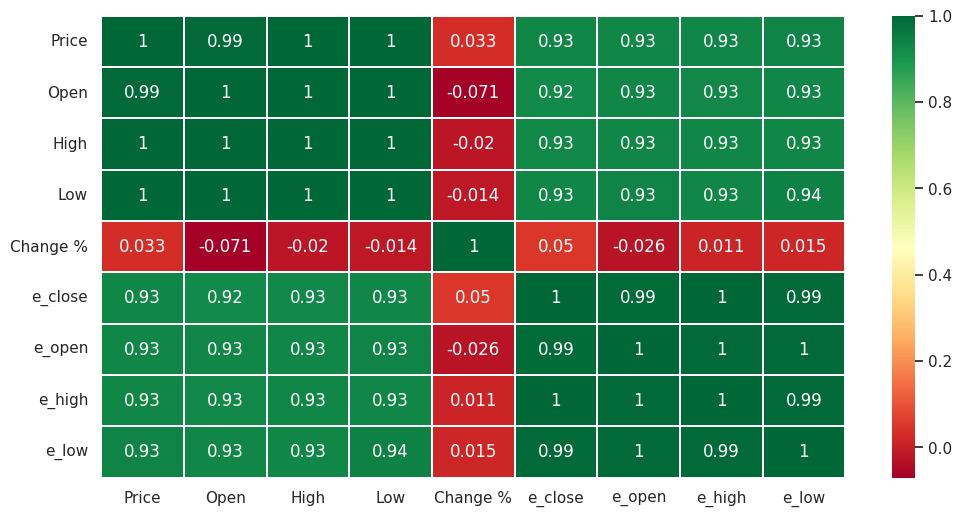

In [14]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, annot_kws={'size': 12});

Разложим временной ряд на компоненты: тренд, сезонность и шум

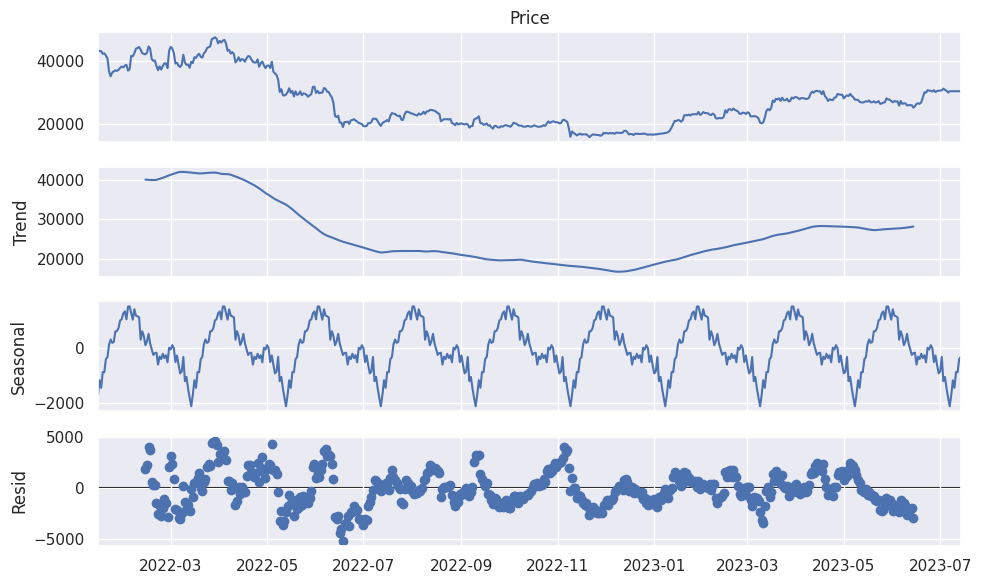

In [15]:
sns.set(rc={'figure.figsize':(10, 6)})

sd = seasonal_decompose(data[TARGET], period=60, model='additive')
sd.plot()
plt.show()

Временной ряд является нестационарным, т.к. присутствуют тренд и сезонность.

## Функции подготовки данных и оптимизации модели

Функция для подсчета среднего значения

In [16]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

Функция для извлечения дополнительных признаков и разделения данных на тренировочную и тестовую части

In [17]:
def preprocess_data(data, lag_start=5, lag_end=10, test_size=7):

    data = pd.DataFrame(data.copy())

    # читаем список признаков
    cols = list(data.columns)

    # рассчитываем индекс тестовой выборки
    # если размер выборки указана в долях, вычисляем ее от размера всей выборки
    if test_size < 1:
        test_size = int(len(data) * test_size)

    test_index = int(len(data) - test_size)

    # заменяем исходные признаки тестовой выборки значениями последнего элемента тренировочной выборки
    for col in cols:
        data[col][test_index:] = float(data[col][test_index-1:test_index])

    # добавляем лаги исходного ряда в качестве признаков
    for f in [TARGET]:
        for i in range(lag_start, lag_end):
            data[f"{f}_lag_{i}"] = data[f].shift(i)

    data['day'] = data.index.day

    # считаем средние только по тренировочной части, чтобы избежать лика
    data['day_average'] = list(map(code_mean(data[:test_index], 'day', TARGET).get, data.day))

    # исключаем признаки, закодированные средними значениями
    data.drop(['day'], axis=1, inplace=True)

    # удаляем пустые значения, сбрасываем индекс
    data = data.dropna()
    data = data.reset_index(drop=True)

    # пересчитываем индекс тестовой выборки после удаления пустых значений
    test_index = int(len(data) - test_size)

    # разбиваем весь датасет на тренировочную и тестовую выборки
    X_train = data[:test_index].drop([TARGET], axis=1)
    y_train = data[:test_index][TARGET]
    X_test = data[test_index:].drop([TARGET], axis=1)
    y_test = data[test_index:][TARGET]

    # возвращаем тренировочную и тестовую выборки датасета
    return X_train, X_test, y_train, y_test

Функция кросс-валидации

In [18]:
def cross_validation(x, d, folds=5):
    # подбираемые параметры
    lag_s, lag_e = x

    # вектор метрик для каждой из валидаций
    scores = []

    for shift in range(folds):
        # выбираем данные, сдвигая окно
        shift_size = shift * TEST_SIZE
        if shift_size == 0:
            dt = d
        else:
            dt = d[:-shift_size]

        # выделяем тренировочную и валидационную части
        X_train, X_valid, y_train, y_valid = preprocess_data(
            dt,
            lag_start=lag_s,
            lag_end=lag_e,
            test_size=TEST_SIZE
        )

        # обучаем модель, считаем метрику
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=False)
        y_pred = model.predict(X_valid)
        mae = mean_absolute_error(y_valid, y_pred)
        scores.append(mae)

    cv_score = np.mean(np.array(scores))

    # возвращаем среднее значение метрики
    return cv_score

Функция поиска оптимальных параметров модели

In [19]:
def model_optimize(ds, params, verbose=False):
    best_params = [0, 0]
    best_score = 0
    params_stat = {
        'start': {},
        'end': {}
    }
    params_stat_count = {
        'start': 0,
        'end': 0
    }
    params_grid = {}

    # интервал и шаг параметров
    start_range, end_range = params

    # перебираем значения параметров и записываем среднюю метрику для кросс-валидации
    for end in range(end_range[0], end_range[1] + end_range[2], end_range[2]):

        for start in range(start_range[0], start_range[1] + start_range[2], start_range[2]):

            mae = cross_validation([start, end], d=ds, folds=FOLDS_N)

            if best_score == 0 or (best_score > 0 and mae < best_score):
                best_score = mae
                best_params = [start, end]

            start_index = str(start)
            if start_index in params_stat['start']:
                params_stat['start'][start_index] += mae
            else:
                params_stat['start'][start_index] = mae
                params_stat_count['end'] += 1

            end_index = str(end)
            if end_index in params_stat['end']:
                params_stat['end'][end_index] += mae
            else:
                params_stat['end'][end_index] = mae
                params_stat_count['start'] += 1

            if end not in params_grid:
                params_grid[end] = {}
            params_grid[end][start] = mae

            if verbose:
                print(f"{start}-{end}: {mae:0.2f}")

    # вычисляем среднее значение для каждого варианта параметра
    for sk, sv in params_stat.items():
        params_stat[sk] = {k: v / params_stat_count[sk] for k, v in sv.items()}

    # возвращаем лучшую метрику, лучший набор параметров, средние метрики, а также матрицу метрик для сочетаний параметров
    return best_score, best_params, params_stat, params_grid

## Оптимизация параметров модели

Установим общие параметры модели

In [20]:
model_params = {
    'n_estimators': 900,
    'verbose': False,
    'random_seed': RANDOM_SEED
}

In [21]:
model = CatBoostRegressor(**model_params)

Найдем оптимальные значения параметров

In [22]:
best_score, best_params, params_stat, params_grid = model_optimize(data_valid, [[7, 10, 1], [15, 35, 5]])

# лучшие параметры
lag_start_min, lag_end_min = best_params

# оптимальные параметры
lag_start_opt = int(min(params_stat['start'], key=params_stat['start'].get))
lag_end_opt = int(min(params_stat['end'], key=params_stat['end'].get))

Выведем результаты оптимизации

In [23]:
print(f'Folds: {FOLDS_N}\nBest score: {best_score:0.2f}\nBest parameters: lag_start = {lag_start_min}, lag_end = {lag_end_min}\n' \
      f'Optimal parameters: lag_start = {lag_start_opt}, lag_end = {lag_end_opt}')

Folds: 10
Best score: 134.07
Best parameters: lag_start = 8, lag_end = 30
Optimal parameters: lag_start = 9, lag_end = 30


Выведем диаграмму метрики для всех сочетаний параметров, а также среднюю величину метрики для отдельных значений подбираемых параметров

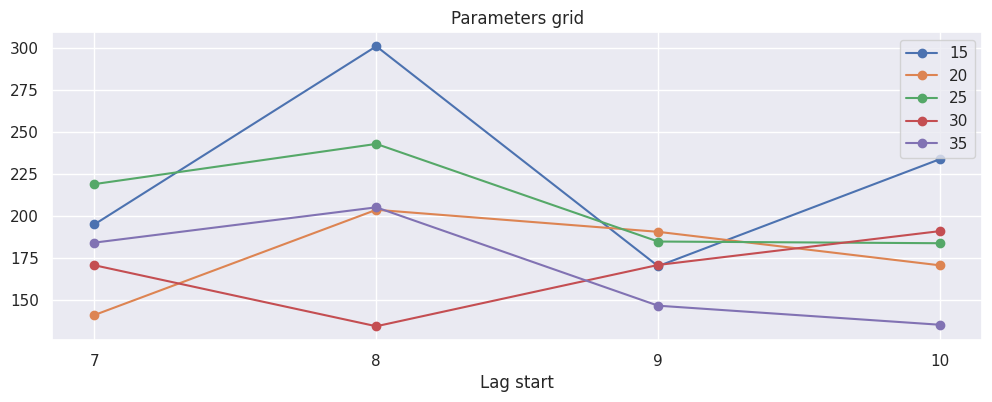

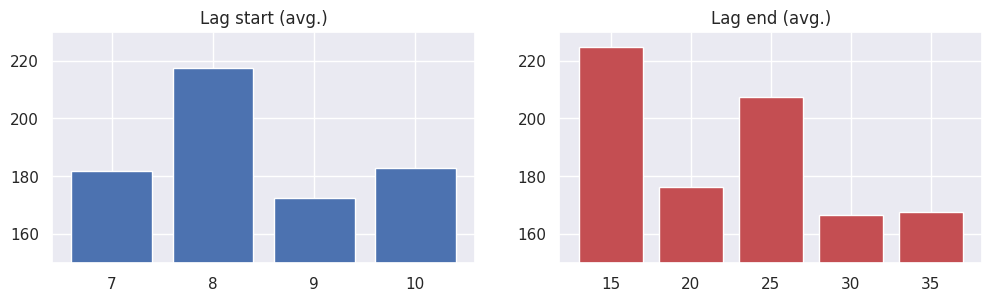

In [24]:
plt.figure(figsize=(12, 4))
plt.title(f'Parameters grid');
for lag_end_key, lag_end_set in params_grid.items():
    plt.plot(list(params_grid[lag_end_key].keys()), list(params_grid[lag_end_key].values()), 'o-', label=lag_end_key)
    plt.legend(loc='upper right')
    plt.xticks(list(params_grid[lag_end_key].keys()))
    plt.xlabel('Lag start')

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].bar(list(params_stat['start'].keys()), list(params_stat['start'].values()))
ax[0].set_xticks(list(params_stat['start'].keys()))
ax[0].set_title(f'Lag start (avg.)');
ax[0].set_ylim([150, 230])

ax[1].bar(list(params_stat['end'].keys()), list(params_stat['end'].values()), color='r')
ax[1].set_xticks(list(params_stat['end'].keys()))
ax[1].set_title(f'Lag end (avg.)');
ax[1].set_ylim([150, 230])

plt.show()

### Перебор оптимальных сочетаний параметров

Рассчитаем и сохраним прогнозы модели на тестовых данных, перебирая ряд параметров с фиксированием значения оптимального параметра

In [25]:
# ряд для оптимального значения lag_start_opt
for lag_end in range(15, 40, 5):
    X_train, X_test, y_train, y_test = preprocess_data(data, lag_start=lag_start_opt, lag_end=lag_end, test_size=TEST_SIZE)

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    X_test['Date'] = data.index[-len(y_test):]
    X_test[TARGET] = preds
    X_test.set_index('Date', inplace=True)

    X_result = X_test[[TARGET]]

    # сохраним прогноз в файл
    X_result.to_csv(f'prediction_catboost_{lag_start_opt}-{lag_end}.csv')

# ряд для оптимального значения lag_end_opt
for lag_start in range(7, 11, 1):
    X_train, X_test, y_train, y_test = preprocess_data(data, lag_start=lag_start, lag_end=lag_end_opt, test_size=TEST_SIZE)

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    X_test['Date'] = data.index[-len(y_test):]
    X_test[TARGET] = preds
    X_test.set_index('Date', inplace=True)

    X_result = X_test[[TARGET]]

    # сохраним прогноз в файл
    X_result.to_csv(f'prediction_catboost_{lag_start}-{lag_end_opt}.csv')

### Лучший вариант

Параметры:

* lag_start = 9
* lag_end = 35

Результат на kaggle: **212.58**

### Обучение модели и прогнозирование

Рассчитаем прогноз модели с лучшими подобранными параметрами на тестовых данных

In [26]:
lag_start_win, lag_end_win = [9, 35]

In [27]:
X_train, X_test, y_train, y_test = preprocess_data(data, lag_start=lag_start_win, lag_end=lag_end_win, test_size=TEST_SIZE)

print('Test length:', len(y_test))

X_test

Test length: 7


,Open,High,Low,Change %,e_close,e_open,e_high,e_low,Price_lag_9,Price_lag_10,...,Price_lag_26,Price_lag_27,Price_lag_28,Price_lag_29,Price_lag_30,Price_lag_31,Price_lag_32,Price_lag_33,Price_lag_34,day_average
506,29912.7,30442.0,29757.4,1.45,170711.191071,168568.662245,172040.631311,167155.604005,30445.7,30078.6,...,25906.8,25928.4,25844.0,26479.3,26501.1,26342.5,27230.2,25747.4,27122.3,26655.282353
507,29912.7,30442.0,29757.4,1.45,170711.191071,168568.662245,172040.631311,167155.604005,30472.9,30445.7,...,25929.4,25906.8,25928.4,25844.0,26479.3,26501.1,26342.5,27230.2,25747.4,26447.405882
508,29912.7,30442.0,29757.4,1.45,170711.191071,168568.662245,172040.631311,167155.604005,30586.8,30472.9,...,25129.5,25929.4,25906.8,25928.4,25844.0,26479.3,26501.1,26342.5,27230.2,26340.988235
509,29912.7,30442.0,29757.4,1.45,170711.191071,168568.662245,172040.631311,167155.604005,30617.7,30586.8,...,25591.3,25129.5,25929.4,25906.8,25928.4,25844.0,26479.3,26501.1,26342.5,25906.705882
510,29912.7,30442.0,29757.4,1.45,170711.191071,168568.662245,172040.631311,167155.604005,31151.3,30617.7,...,26341.3,25591.3,25129.5,25929.4,25906.8,25928.4,25844.0,26479.3,26501.1,25952.376471
511,29912.7,30442.0,29757.4,1.45,170711.191071,168568.662245,172040.631311,167155.604005,30768.4,31151.3,...,26515.0,26341.3,25591.3,25129.5,25929.4,25906.8,25928.4,25844.0,26479.3,25881.064706
512,29912.7,30442.0,29757.4,1.45,170711.191071,168568.662245,172040.631311,167155.604005,30512.8,30768.4,...,26339.7,26515.0,26341.3,25591.3,25129.5,25929.4,25906.8,25928.4,25844.0,27030.555556


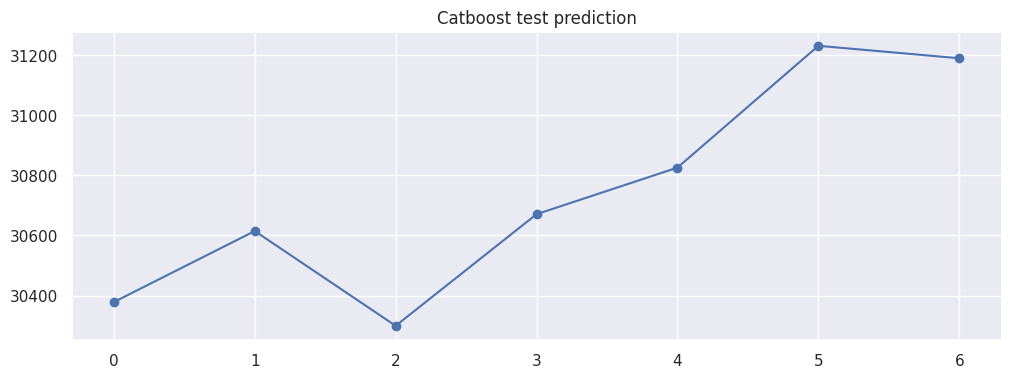

In [28]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

plt.figure(figsize=(12, 4))
plt.plot(preds, 'o-', label='prediction')
plt.grid(True)
plt.title(f"Catboost test prediction");
plt.show()

Выведем график значимости признаков

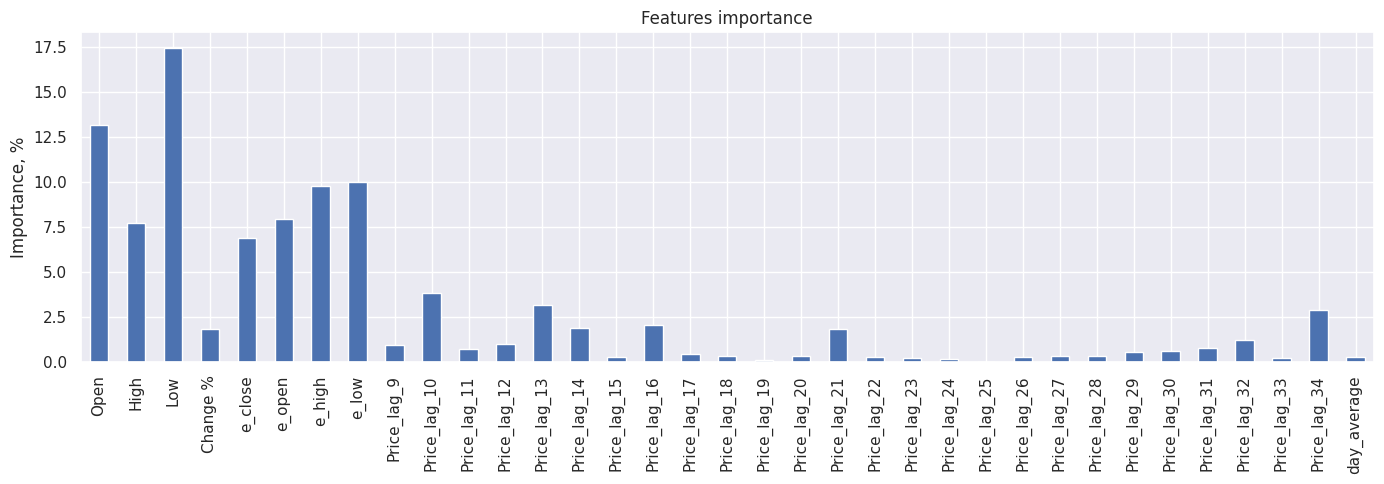

In [29]:
features_strength = pd.Series(model.get_feature_importance(), X_test.columns)
fig, ax = plt.subplots(figsize=(14, 5))
features_strength.plot.bar(ax=ax)
ax.set_title('Features importance')
ax.set_ylabel('Importance, %')
fig.tight_layout()

## Экспериментальная модель

In [30]:
model_2_params = {
    'n_estimators': 600,
    'verbose': False,
    'random_seed': RANDOM_SEED
}

In [31]:
model = CatBoostRegressor(**model_2_params)

In [32]:
# лучшие параметры
lag_start_min_2, lag_end_min_2 = [5, 25]

Рассчитаем прогноз модели с минимальными параметрами на тестовых данных

In [33]:
X_train, X_test, y_train, y_test = preprocess_data(data, lag_start=lag_start_min_2, lag_end=lag_end_min_2, test_size=TEST_SIZE)

print('Test length:', len(y_test))

X_test

Test length: 7


,Open,High,Low,Change %,e_close,e_open,e_high,e_low,Price_lag_5,Price_lag_6,...,Price_lag_16,Price_lag_17,Price_lag_18,Price_lag_19,Price_lag_20,Price_lag_21,Price_lag_22,Price_lag_23,Price_lag_24,day_average
516,29912.7,30442.0,29757.4,1.45,170711.191071,168568.662245,172040.631311,167155.604005,31151.3,30617.7,...,29890.5,29996.9,28307.7,26845.9,26339.7,26515.0,26341.3,25591.3,25129.5,26655.282353
517,29912.7,30442.0,29757.4,1.45,170711.191071,168568.662245,172040.631311,167155.604005,30768.4,31151.3,...,30679.4,29890.5,29996.9,28307.7,26845.9,26339.7,26515.0,26341.3,25591.3,26447.405882
518,29912.7,30442.0,29757.4,1.45,170711.191071,168568.662245,172040.631311,167155.604005,30512.8,30768.4,...,30533.6,30679.4,29890.5,29996.9,28307.7,26845.9,26339.7,26515.0,26341.3,26340.988235
519,29912.7,30442.0,29757.4,1.45,170711.191071,168568.662245,172040.631311,167155.604005,29913.1,30512.8,...,30465.3,30533.6,30679.4,29890.5,29996.9,28307.7,26845.9,26339.7,26515.0,25906.705882
520,29912.7,30442.0,29757.4,1.45,170711.191071,168568.662245,172040.631311,167155.604005,30346.4,29913.1,...,30267.0,30465.3,30533.6,30679.4,29890.5,29996.9,28307.7,26845.9,26339.7,25952.376471
521,29912.7,30442.0,29757.4,1.45,170711.191071,168568.662245,172040.631311,167155.604005,30346.4,30346.4,...,30689.1,30267.0,30465.3,30533.6,30679.4,29890.5,29996.9,28307.7,26845.9,25881.064706
522,29912.7,30442.0,29757.4,1.45,170711.191071,168568.662245,172040.631311,167155.604005,30346.4,30346.4,...,30078.6,30689.1,30267.0,30465.3,30533.6,30679.4,29890.5,29996.9,28307.7,27030.555556


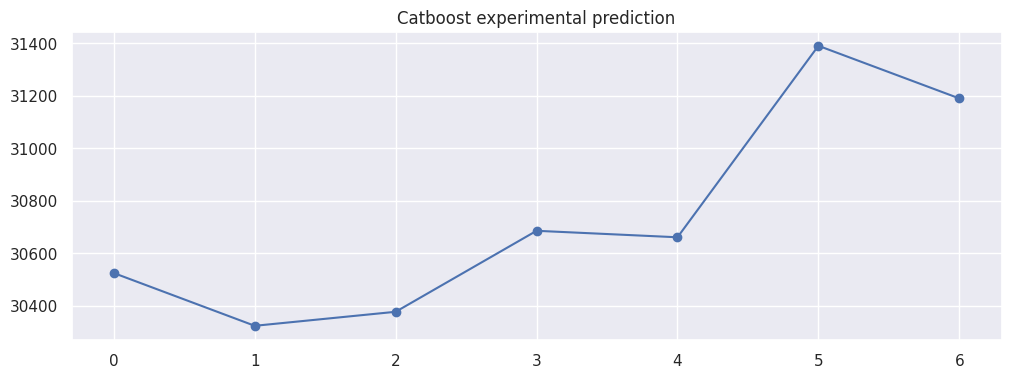

In [34]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

plt.figure(figsize=(12, 4))
plt.plot(preds, 'o-', label='prediction')
plt.grid(True)
plt.title(f"Catboost experimental prediction");
plt.show()

Выведем график значимости признаков

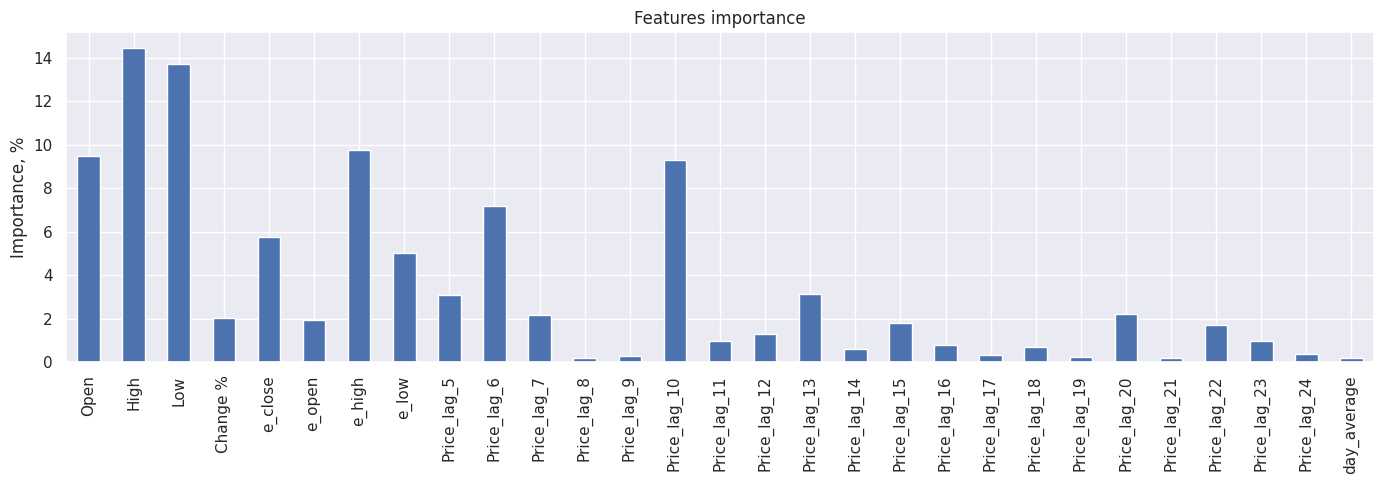

In [35]:
features_strength = pd.Series(model.get_feature_importance(), X_test.columns)
fig, ax = plt.subplots(figsize=(14, 5))
features_strength.plot.bar(ax=ax)
ax.set_title('Features importance')
ax.set_ylabel('Importance, %')
fig.tight_layout()

Сохраним результаты в файл

In [36]:
X_test['Date'] = data.index[-len(y_test):]
X_test[TARGET] = preds
X_test.set_index('Date', inplace=True)

X_result = X_test[[TARGET]]

# сохраним прогноз в файл
X_result.to_csv(f'prediction_catboost_exp_{lag_start_min_2}-{lag_end_min_2}.csv')

Результат на kaggle: **136.23**

 ## Модель NaiveForecaster библиотеки sktime

In [ ]:
!pip install sktime

In [38]:
from sktime.forecasting.naive import NaiveForecaster

In [39]:
lag_start_nf = 7
lag_end_nf = 25
sp_nf = 7

<function matplotlib.pyplot.show(close=None, block=None)>

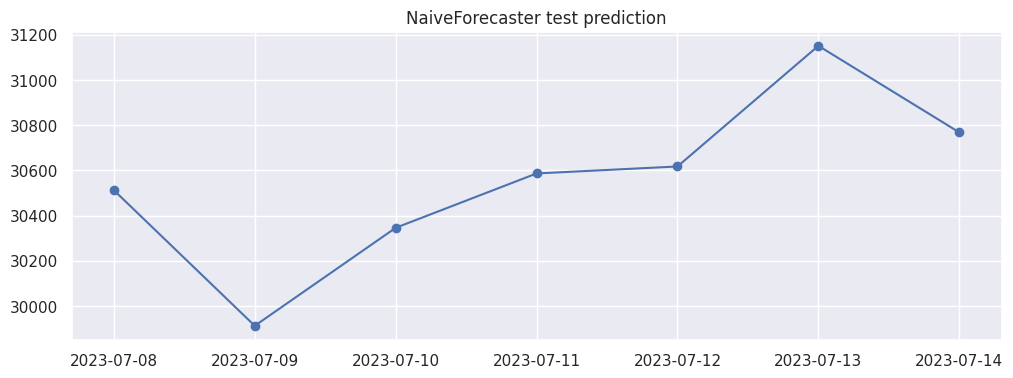

In [40]:
X_train, X_test, y_train, y_test = preprocess_data(data, lag_start=lag_start_nf, lag_end=lag_end_nf, test_size=TEST_SIZE)

fh = np.array(y_train.index)
fh = pd.DataFrame(X_test.index)
fh = np.array(fh[0].to_numpy())

forecaster = NaiveForecaster(sp=sp_nf)
forecaster.fit(y_train, X=X_train, fh=fh)
preds = forecaster.predict(X=X_test, fh=fh)

X_test['Date'] = data.index[-len(y_test):]
X_test[TARGET] = preds.values
X_test.set_index('Date', inplace=True)

X_result = X_test[[TARGET]]

plt.figure(figsize=(12, 4))
plt.plot(X_result, 'o-', label="prediction")

plt.grid(True)
plt.title(f"NaiveForecaster test prediction")
plt.show

In [41]:
X_result.to_csv(f'prediction_naive_sp-{sp_nf}_{lag_start_nf}-{lag_end_nf}.csv')

Результат на kaggle: **237.54**